# GIS Practicum Project
____________________________________
## Impact of Extreme Weather Events on Railway Incidents
### Determining high risk locations where monitoring stations could be installed

Data Sources:

    1. NOAA Reference Data:
        - source: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/
        - local files: ghcnd-stations.txt & ghcnd-states.txt
        - use: reference data for daily weather station files
    2. NOAA Daily Weather Data:
        - source: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/
        - local files: ghcnd_hcn.tar.gz
        - use: granular weather data by station
    3. U.S. Cities Data:
        - source: https://github.com/kelvins/US-Cities-Database/blob/main/csv/us_cities.csv
        - local files: us_cities.csv
        - use: mapping between datasets
    4. Railroad Grade Crossing Incident Data:
        - source:
        - local files: Highway-Rail_Grade_Crossing_Accident_Data.csv
        - use: main incident dataset
    5. Weather Events:
        - source: https://www.kaggle.com/sobhanmoosavi/us-weather-events
        - local file: WeatherEvents_Jan2016-Dec2020.csv
        - use: major U.S. weather events, 6.3m over 5yr period
    6. Major Safety events
    7. Time Series Safety Events
    
Outline:
    1. Environment setup
    2. Data loading & Preprocessing
    3. EDA & Visualization
    4. Prep for scikit learn
    5. Model Building & Evaluation

## 1. Environment Setup
___

In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
import seaborn as sns

Set Matplotlib Style:

In [2]:
plt.style.use('dark_background')

Get Current Working Directory:

In [3]:
wd = os.getcwd()
print(wd)

C:\Users\thoma\Desktop\Rutgers MBS\Externship Class\Practicum\Project


## 2. Data Loading & Preprocessing
___

### Source 1: NOAA:

#### Stations:

In [4]:
def load_noaa_stations_data(wd):
    """
    This function will load the weather station dataset from NOAA
    this is used for mapping to rail crossing locations.
    
    Contains weather station reference data
    
    Source: ghcnd-stations.txt from NOAA ftp
    Input: wd - working directory
    Output: stations_df - dataframe of NOAA stations
    """
    f = open(os.path.join(wd,"ghcnd-stations.txt"),"r")
    lines = f.readlines()

    # columns in the station file
    colnames = ['ID', 'LAT', 'LON', 'ELEV', 'STATE', 'NAME', 'GSN', 'HCNCRN', 'WMOID']
    stationlist = []

    # initialize dataframe with correct columns
    stations_df = pd.DataFrame(columns=colnames)

    # iterate through stations and add them to our collection of stations if they are in the US
    for line in lines:
        # first 2 characters are the country code , we only care about us stations
        if line[0:2] == 'US':

            # the description of the file seemed slightly off, i tested and found these column numbers to work best
            row = {"ID": line[0:11].upper(),
                    "LAT": float(line[13:20]),
                    "LON": float(line[21:30]),
                    "ELEV": float(line[31:37]),
                    "STATE": line[38:40],
                    "NAME": line[41:71],
                    "GSN": line[72:75],
                    "HCNCRN": line[76:79],
                    "WMOID": line[80:85]
                   }
            stationlist.append(row)
        else:
            pass
    stations_df = stations_df.append(stationlist)
    f.close()
    
    return stations_df

In [5]:
stations_df = load_noaa_stations_data(wd)

In [6]:
stations_df.head()

,ID,LAT,LON,ELEV,STATE,NAME,GSN,HCNCRN,WMOID
0,US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA),,,
1,US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW,,,
2,US10ADAM001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S,,,
3,US10ADAM002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,,,
4,US10ADAM003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW,,,


#### States:

In [7]:
def load_noaa_states_data(wd):
    """
    This function will load the state dataset from NOAA
    this is used for mapping to rail crossing locations.
    
    Contains state reference data
    
    Source: ghcnd-states.txt from NOAA ftp
    Input: wd - working directory
    Output: states_df - dataframe of NOAA states
    """
    # read in states dataset to supplement weather stations data
    f = open(os.path.join(wd,"ghcnd-states.txt"),"r")
    lines = f.readlines()

    colnames = ['CODE', 'NAME']

    # create dataframe of state data
    states_df = pd.DataFrame(columns=colnames)
    for line in lines:
        modline = line.strip('\n')
        data = {'CODE': line[0:2],
                "NAME": modline[3:50]
               }
        states_df = states_df.append(data, ignore_index=True)    

    f.close()
    return states_df

In [8]:
states_df = load_noaa_states_data(wd)

In [9]:
states_df.head()

,CODE,NAME
0,AB,ALBERTA
1,AK,ALASKA
2,AL,ALABAMA
3,AR,ARKANSAS
4,AS,AMERICAN SAMOA


#### NOAA Reference Data Merge:

In [10]:
def merge_noaa_refdata(stations_df, states_df):
    """
    This function will merge the NOAA refdata
    this is used for mapping to rail crossing locations.
    
    Contains state & station reference data
    
    Input: stations_df, states_df
    Output: stations_plus_df - dataframe of NOAA refdata
    """
    
    # add state data to the stations dataset
    station_plus_df = stations_df.join(states_df.set_index('CODE'), on='STATE', rsuffix='_STATE')

    # create our key feature: coordinateID (wcoordinateID for weather)
    # round latitude & longitude to 1 decimal, combine them in a tuple (lat, lon)
    station_plus_df['wcoordinateID'] = list(zip(round(station_plus_df['LAT'],1),round(station_plus_df['LON'],1)))
    station_plus_df = station_plus_df[['ID','ELEV','wcoordinateID']]
    
    return station_plus_df

In [11]:
station_plus_df = merge_noaa_refdata(stations_df, states_df)

In [12]:
station_plus_df.head()

,ID,ELEV,wcoordinateID
0,US009052008,482.0,"(43.7, -96.6)"
1,US10RMHS145,1569.1,"(40.5, -105.1)"
2,US10ADAM001,598.0,"(40.6, -98.5)"
3,US10ADAM002,601.1,"(40.5, -98.5)"
4,US10ADAM003,615.1,"(40.5, -98.7)"


### Source 3: U.S. Cities:

In [13]:
def load_us_cities_data(wd):
    """
    This function will load cities data which will 
    be used to attach coordinateID to other datasets 
    which only have city or county level data.
    Also derives county locations.
    
    Input: wd - working directory
    Output: grouped_meancounties_df
    """
    cities_df = pd.read_csv(os.path.join(wd,"us_cities.csv"))
    
    # standardize county and state, city is not populated for all events.
    # one change to approach would be to include all cities + the grouped mean of each county
    cities_df['County'] = cities_df['COUNTY'].str.upper()
    cities_df['State'] = cities_df['STATE_NAME'].str.upper()

    # subset of data that we care about, lat+lon to make coordinateID, county, state, state code to merge on
    counties = cities_df[['County','State','LATITUDE','LONGITUDE','STATE_CODE']]
    grouped_counties = counties.groupby(['State','County'])
    grouped_meancounties_df = grouped_counties.mean()
    grouped_meancounties_df = grouped_meancounties_df.reset_index()
    grouped_meancounties_df['wcoordinateID'] = list(zip(round(grouped_meancounties_df['LATITUDE'],1),round(grouped_meancounties_df['LONGITUDE'],1)))
    
    return grouped_meancounties_df

In [14]:
grouped_meancounties_df = load_us_cities_data(wd)

In [15]:
grouped_meancounties_df.head()

,State,County,LATITUDE,LONGITUDE,wcoordinateID
0,ALABAMA,AUTAUGA,32.549984,-86.638759,"(32.5, -86.6)"
1,ALABAMA,BALDWIN,30.583510,-87.732460,"(30.6, -87.7)"
2,ALABAMA,BARBOUR,31.817987,-85.441254,"(31.8, -85.4)"
3,ALABAMA,BIBB,33.027422,-87.071602,"(33.0, -87.1)"
4,ALABAMA,BLOUNT,33.937479,-86.598022,"(33.9, -86.6)"


### Source 4: Rail Crossing Data:

In [16]:
def load_rail_crossing_data(wd, grouped_meancounties_df):
    """
    This function will load data for rail crossings
    which will be used for instances for model training.
    Will also be used to limit weather station observations
    
    Input: wd - working directory, grouped_meancounties_df - location base data
    Output: rail_city_df
    """
    railcrossing_df = pd.read_csv(os.path.join(wd,"Highway-Rail_Grade_Crossing_Accident_Data.csv"))
    
    # gather the fields necessary for coordinateID, as well as any  fields you want for analysis later 
    # change to approache what fields we include in refined_rr
    refined_rr_df = railcrossing_df #[['Incident Number','Date','County Name', 'State Name']]

    # drop any incident without a date
    refined_rr_df = refined_rr_df.dropna(subset=['Date'])

    # create our feature incident date, which is an integer with format: yyyymmdd 
    incident_date = refined_rr_df['Date'].str.split(' ', expand=True)
    incident_date = incident_date[0].str.split('/', expand=True)
    refined_rr_df['incident_date'] = (incident_date[2].astype(int) * 10000) + (incident_date[0].astype(int) * 100) + (incident_date[1].astype(int) * 1)

    # merge accident data with city/county data to add coordinateID to each accident.
    merg_rail_city_df = refined_rr_df.merge(grouped_meancounties_df, how='inner', left_on=['County Name','State Name'], right_on=['County','State'])
    print("Shape of merged unfiltered rail_city dataset:  {}".format(merg_rail_city_df.shape))
    merg_rail_city_df = merg_rail_city_df[merg_rail_city_df['incident_date'] > 20160000]
    merg_rail_city_df = merg_rail_city_df[['Grade Crossing ID', 
                                           'Maintenance Parent Railroad Code', 
                                           'Incident Number',
                                           'Crossing Illuminated',
                                           'Railroad Type',
                                           'Track Type Code', 
                                           'incident_date', 
                                           'wcoordinateID', 
                                           'State', 
                                           'County'
                                          ]]
    print("Shape of merged filtered rail_city dataset:  {}".format(merg_rail_city_df.shape))
    
    return merg_rail_city_df

In [17]:
merg_rail_city_df = load_rail_crossing_data(wd, grouped_meancounties_df)

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (6,7,8,25,26,38,42,50,51,52,53,59,64,69,87,88,89,95,97,98,99,100,101,106,119,122,126,127,128,129,139,147,148,149,150,151,152) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Shape of merged unfiltered rail_city dataset:  (232065, 165)
Shape of merged filtered rail_city dataset:  (11586, 10)


In [18]:
def pre_process_rail(merg_rail_city_df):
    """
    This function will preprocess rail df.
    Focus is on datetime formats
    
    input: merg_rail_city_df
    output: enriched merg_rail_city_df
    """
    
    merg_rail_city_df['incident_datetime'] = pd.to_datetime(merg_rail_city_df['incident_date'], format='%Y%m%d')
    merg_rail_city_df['incident_year'] = merg_rail_city_df['incident_datetime'].dt.year
    merg_rail_city_df['incident_month'] = merg_rail_city_df['incident_datetime'].dt.month
    merg_rail_city_df['incident_year_month'] = merg_rail_city_df['incident_year'].astype(str) + '_' + merg_rail_city_df['incident_month'].astype(str)
    
    return merg_rail_city_df

In [19]:
merg_rail_city_df = pre_process_rail(merg_rail_city_df)

In [20]:
merg_rail_city_df.head()

,Grade Crossing ID,Maintenance Parent Railroad Code,Incident Number,Crossing Illuminated,Railroad Type,Track Type Code,incident_date,wcoordinateID,State,County,incident_datetime,incident_year,incident_month,incident_year_month
3,028445G,BNSF,144902,No,No,1.0,20161031,"(36.7, -119.7)",CALIFORNIA,FRESNO,2016-10-31,2016,10,2016_10
6,028574W,BNSF,CA0918203,Yes,CL,1.0,20180930,"(36.7, -119.7)",CALIFORNIA,FRESNO,2018-09-30,2018,9,2018_9
7,756879C,UP,0320NC060,Yes,CL,1.0,20200325,"(36.7, -119.7)",CALIFORNIA,FRESNO,2020-03-25,2020,3,2020_3
8,757394K,UP,0318RS031,Unknown,CL,1.0,20180321,"(36.7, -119.7)",CALIFORNIA,FRESNO,2018-03-21,2018,3,2018_3
9,756864M,UP,0318RS033,No,CL,1.0,20180323,"(36.7, -119.7)",CALIFORNIA,FRESNO,2018-03-23,2018,3,2018_3


In [21]:
monthly_counts_df = merg_rail_city_df.groupby(['incident_month'])['Incident Number'].nunique().to_frame().reset_index()

monthly_counts_df

,incident_month,Incident Number
0,1,1091
1,2,992
2,3,976
3,4,877
4,5,922
5,6,1003
6,7,1035
7,8,1036
8,9,850
9,10,892


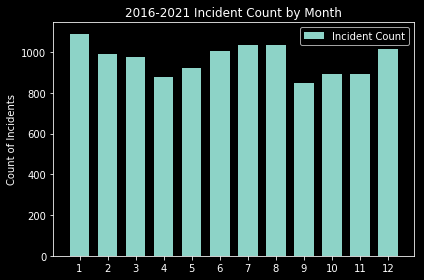

In [22]:
fig, ax = plt.subplots()
x = np.arange(len(monthly_counts_df['incident_month']))
width = 0.7

rects1 = ax.bar(x, monthly_counts_df['Incident Number'], width, label = 'Incident Count')
#rects2 = ax.bar(x + width/2, mode2_stats_df['Total Fatalities'], width, label = 'Incidents w Fatalities')

ax.set_title('2016-2021 Incident Count by Month')
ax.set_ylabel('Count of Incidents')
ax.set_xticks(x)
ax.set_xticklabels(monthly_counts_df['incident_month'])
ax.legend()

fig.tight_layout()

plt.show()

Filter Weather Stations:

In [23]:
# dataframe of weather stations - only those that share coordinateID with an accident
merged_stations_incidents_df = station_plus_df.merge(merg_rail_city_df,left_on='wcoordinateID', right_on='wcoordinateID', how='inner')

In [24]:
merged_stations_incidents_df.head()

,ID,ELEV,wcoordinateID,Grade Crossing ID,Maintenance Parent Railroad Code,Incident Number,Crossing Illuminated,Railroad Type,Track Type Code,incident_date,State,County,incident_datetime,incident_year,incident_month,incident_year_month
0,US10ADAM002,601.1,"(40.5, -98.5)",070783N,BNSF,PR0221201,Yes,CL,1.0,20210204,NEBRASKA,ADAMS,2021-02-04,2021,2,2021_2
1,US10ADAM002,601.1,"(40.5, -98.5)",977598D,BNSF,PR0820201,No,CL,2.0,20200814,NEBRASKA,ADAMS,2020-08-14,2020,8,2020_8
2,US10ADAM002,601.1,"(40.5, -98.5)",083186U,BNSF,PR0916200,No,CL,1.0,20160912,NEBRASKA,ADAMS,2016-09-12,2016,9,2016_9
3,US10ADAM002,601.1,"(40.5, -98.5)",070769T,BNSF,PR0918208,No,CL,1.0,20180928,NEBRASKA,ADAMS,2018-09-28,2018,9,2018_9
4,US10ADAM002,601.1,"(40.5, -98.5)",813281H,UP,0718NP018,No,CL,1.0,20180712,NEBRASKA,ADAMS,2018-07-12,2018,7,2018_7


In [25]:
merged_stations_incidents_df.shape

(42326, 16)

In [26]:
weather_station_crossings = merged_stations_incidents_df.groupby(['ID'])['Grade Crossing ID'].nunique().to_frame().sort_values('Grade Crossing ID', ascending=False)

In [27]:
weather_station_incidents = merged_stations_incidents_df.groupby(['ID'])['Incident Number'].nunique().to_frame().sort_values('Incident Number', ascending=False)

In [28]:
weather_station_stats = weather_station_crossings.merge(weather_station_incidents, how="outer", on="ID")

In [29]:
weather_station_stats.fillna(0, inplace=True)

In [30]:
weather_station_stats.head()

,Grade Crossing ID,Incident Number
ID,,
US1ILCK0286,185,271
US1ILCK0012,185,271
USC00118278,185,271
US1ILCK0300,185,271
US1ILCK0298,185,271


In [31]:
weather_station_stats.shape

(3784, 2)

In [32]:
weather_station_stats.mean()

Grade Crossing ID     8.568710
Incident Number      11.185518
dtype: float64

In [33]:
weather_station_stats.max()

Grade Crossing ID    185
Incident Number      271
dtype: int64

In [34]:
weather_station_stats.min()

Grade Crossing ID    1
Incident Number      1
dtype: int64

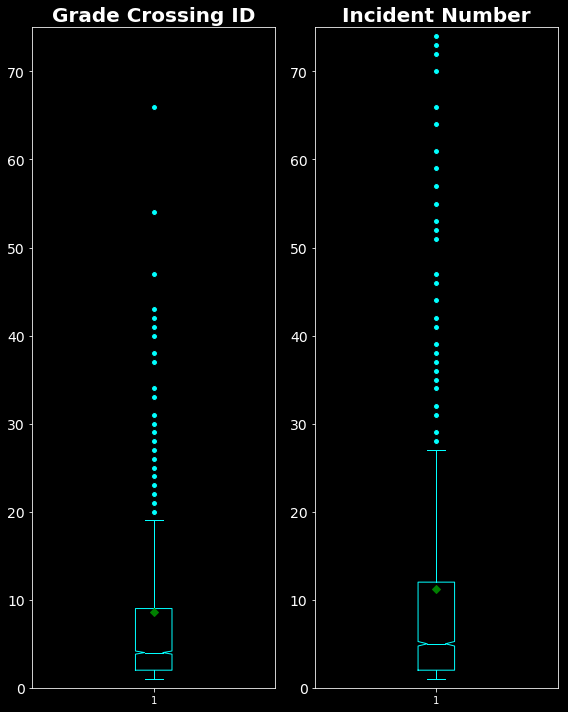

In [35]:
blue_circle = dict(markerfacecolor='cyan', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

df = weather_station_stats
c = 'cyan'

fig, axs = plt.subplots(1, len(df.columns), figsize=(8,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df.iloc[:,i], boxprops=dict(color=c), capprops=dict(color=c), whiskerprops=dict(color=c), medianprops=dict(color=c), flierprops=blue_circle, showmeans=True, meanprops=mean_shape, notch=True, vert=True)
    ax.set_title(df.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, 75)
    
plt.tight_layout()
plt.show()

#### State filtering here:

In [36]:
target_states = ['NEW JERSEY','NEW YORK','PENNSYLVANIA','CONNECTICUT','DELAWARE','MARYLAND','MASSACHUSETTS','NEW HAMPSHIRE','VIRGINIA']
target_state_codes = ['NJ', 'NY', 'PA', 'CT', 'DE', 'MD', 'MA', 'NH', 'VA']

In [37]:
merged_stations_incidents_df = merged_stations_incidents_df[merged_stations_incidents_df['State'].isin(target_states)]

In [38]:
merged_stations_incidents_df.shape

(4021, 16)

In [39]:
merged_stations_incidents_df.head()

,ID,ELEV,wcoordinateID,Grade Crossing ID,Maintenance Parent Railroad Code,Incident Number,Crossing Illuminated,Railroad Type,Track Type Code,incident_date,State,County,incident_datetime,incident_year,incident_month,incident_year_month
7202,US1CTFR0064,196.0,"(41.3, -73.4)",500593A,MNCW,71209,Yes,No,1.0,20200104,CONNECTICUT,FAIRFIELD,2020-01-04,2020,1,2020_1
7203,US1CTFR0064,196.0,"(41.3, -73.4)",500536L,MNCW,2016012406,No,No,1.0,20160124,CONNECTICUT,FAIRFIELD,2016-01-24,2016,1,2016_1
7204,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2016012622,No,No,1.0,20160126,CONNECTICUT,FAIRFIELD,2016-01-26,2016,1,2016_1
7205,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2019141,No,No,1.0,20190831,CONNECTICUT,FAIRFIELD,2019-08-31,2019,8,2019_8
7206,US1CTFR0064,196.0,"(41.3, -73.4)",500578X,MNCW,68702,Unknown,No,1.0,20181106,CONNECTICUT,FAIRFIELD,2018-11-06,2018,11,2018_11


In [40]:
inc_counts_df = merged_stations_incidents_df.groupby(['wcoordinateID', 'incident_year_month'])['Incident Number'].count().to_frame().reset_index().rename(columns={'Incident Number': 'Incident Count'})
fin_df = merged_stations_incidents_df.merge(inc_counts_df, how="left", on=['wcoordinateID', 'incident_year_month'])

In [41]:
fin_df.head()

,ID,ELEV,wcoordinateID,Grade Crossing ID,Maintenance Parent Railroad Code,Incident Number,Crossing Illuminated,Railroad Type,Track Type Code,incident_date,State,County,incident_datetime,incident_year,incident_month,incident_year_month,Incident Count
0,US1CTFR0064,196.0,"(41.3, -73.4)",500593A,MNCW,71209,Yes,No,1.0,20200104,CONNECTICUT,FAIRFIELD,2020-01-04,2020,1,2020_1,2
1,US1CTFR0064,196.0,"(41.3, -73.4)",500536L,MNCW,2016012406,No,No,1.0,20160124,CONNECTICUT,FAIRFIELD,2016-01-24,2016,1,2016_1,4
2,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2016012622,No,No,1.0,20160126,CONNECTICUT,FAIRFIELD,2016-01-26,2016,1,2016_1,4
3,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2019141,No,No,1.0,20190831,CONNECTICUT,FAIRFIELD,2019-08-31,2019,8,2019_8,2
4,US1CTFR0064,196.0,"(41.3, -73.4)",500578X,MNCW,68702,Unknown,No,1.0,20181106,CONNECTICUT,FAIRFIELD,2018-11-06,2018,11,2018_11,2


In [42]:
fin_df['Incident Count'].fillna(0, inplace=True)

In [43]:
pre_2021_incidents = fin_df[fin_df['incident_year'].isin([2016,2017,2018,2019,2020])]
in_2021_incidents = fin_df[fin_df['incident_year'].isin([2021])]

In [44]:
merged_stations_incidents_df.head()

,ID,ELEV,wcoordinateID,Grade Crossing ID,Maintenance Parent Railroad Code,Incident Number,Crossing Illuminated,Railroad Type,Track Type Code,incident_date,State,County,incident_datetime,incident_year,incident_month,incident_year_month
7202,US1CTFR0064,196.0,"(41.3, -73.4)",500593A,MNCW,71209,Yes,No,1.0,20200104,CONNECTICUT,FAIRFIELD,2020-01-04,2020,1,2020_1
7203,US1CTFR0064,196.0,"(41.3, -73.4)",500536L,MNCW,2016012406,No,No,1.0,20160124,CONNECTICUT,FAIRFIELD,2016-01-24,2016,1,2016_1
7204,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2016012622,No,No,1.0,20160126,CONNECTICUT,FAIRFIELD,2016-01-26,2016,1,2016_1
7205,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2019141,No,No,1.0,20190831,CONNECTICUT,FAIRFIELD,2019-08-31,2019,8,2019_8
7206,US1CTFR0064,196.0,"(41.3, -73.4)",500578X,MNCW,68702,Unknown,No,1.0,20181106,CONNECTICUT,FAIRFIELD,2018-11-06,2018,11,2018_11


In [45]:
merged_stations_incidents_df.shape

(4021, 16)

In [46]:
just_stations_df = fin_df #[['Grade Crossing ID','ID', 'ELEV', 'wcoordinateID', 'State', 'County', 'Incidents Before 2021', 'Incidents In 2021', 'Total Incidents']]

In [47]:
just_stations_df.shape

(4021, 17)

In [48]:
just_stations_df.head()

,ID,ELEV,wcoordinateID,Grade Crossing ID,Maintenance Parent Railroad Code,Incident Number,Crossing Illuminated,Railroad Type,Track Type Code,incident_date,State,County,incident_datetime,incident_year,incident_month,incident_year_month,Incident Count
0,US1CTFR0064,196.0,"(41.3, -73.4)",500593A,MNCW,71209,Yes,No,1.0,20200104,CONNECTICUT,FAIRFIELD,2020-01-04,2020,1,2020_1,2
1,US1CTFR0064,196.0,"(41.3, -73.4)",500536L,MNCW,2016012406,No,No,1.0,20160124,CONNECTICUT,FAIRFIELD,2016-01-24,2016,1,2016_1,4
2,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2016012622,No,No,1.0,20160126,CONNECTICUT,FAIRFIELD,2016-01-26,2016,1,2016_1,4
3,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2019141,No,No,1.0,20190831,CONNECTICUT,FAIRFIELD,2019-08-31,2019,8,2019_8,2
4,US1CTFR0064,196.0,"(41.3, -73.4)",500578X,MNCW,68702,Unknown,No,1.0,20181106,CONNECTICUT,FAIRFIELD,2018-11-06,2018,11,2018_11,2


In [49]:
ref_df = fin_df[['wcoordinateID',
                'ID',
                'Grade Crossing ID',
                 'ELEV',
                 'Maintenance Parent Railroad Code',
                 'Crossing Illuminated',
                 'Railroad Type',
                 'Track Type Code',
                 'State',
                 'County'
                ]]

In [50]:
ref_df.shape

(4021, 10)

In [51]:
ref_df.drop_duplicates(inplace=True)

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
ref_df.shape

(3453, 10)

In [53]:
test_df = just_stations_df[['wcoordinateID',
                           'ID',
                           'Grade Crossing ID',
                            'incident_year',
                           'incident_year_month',
                           'Incident Count']]

In [54]:
test_df.shape

(4021, 6)

In [55]:
test_df.drop_duplicates(inplace=True)

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
test_df.shape

(3981, 6)

In [57]:
test_df.head()

,wcoordinateID,ID,Grade Crossing ID,incident_year,incident_year_month,Incident Count
0,"(41.3, -73.4)",US1CTFR0064,500593A,2020,2020_1,2
1,"(41.3, -73.4)",US1CTFR0064,500536L,2016,2016_1,4
2,"(41.3, -73.4)",US1CTFR0064,500557E,2016,2016_1,4
3,"(41.3, -73.4)",US1CTFR0064,500557E,2019,2019_8,2
4,"(41.3, -73.4)",US1CTFR0064,500578X,2018,2018_11,2


In [58]:
test_df[test_df['incident_year']==2021].shape

(412, 6)

In [59]:
def assign_risk_class(x):
    """Assigns a risk_class label."""
    x = int(x)
    if x > 6:
        label = 'High'
    elif x > 0 & x <= 6:
        label = 'Medium'
    else:
        label = 'Low'
        
    return label

def risk_in_21(x):
    """True if >0 else False."""
    x = int(x)
    if x>1:
        label = 'High'
    elif x == 1:
        label = 'Medium'
    else:
        label = 'Low'
        
    return label

In [60]:
pre_2021_incidents.head()

,ID,ELEV,wcoordinateID,Grade Crossing ID,Maintenance Parent Railroad Code,Incident Number,Crossing Illuminated,Railroad Type,Track Type Code,incident_date,State,County,incident_datetime,incident_year,incident_month,incident_year_month,Incident Count
0,US1CTFR0064,196.0,"(41.3, -73.4)",500593A,MNCW,71209,Yes,No,1.0,20200104,CONNECTICUT,FAIRFIELD,2020-01-04,2020,1,2020_1,2
1,US1CTFR0064,196.0,"(41.3, -73.4)",500536L,MNCW,2016012406,No,No,1.0,20160124,CONNECTICUT,FAIRFIELD,2016-01-24,2016,1,2016_1,4
2,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2016012622,No,No,1.0,20160126,CONNECTICUT,FAIRFIELD,2016-01-26,2016,1,2016_1,4
3,US1CTFR0064,196.0,"(41.3, -73.4)",500557E,MNCW,2019141,No,No,1.0,20190831,CONNECTICUT,FAIRFIELD,2019-08-31,2019,8,2019_8,2
4,US1CTFR0064,196.0,"(41.3, -73.4)",500578X,MNCW,68702,Unknown,No,1.0,20181106,CONNECTICUT,FAIRFIELD,2018-11-06,2018,11,2018_11,2


In [61]:
pre_2021_incidents['risk_class'] = pre_2021_incidents['Incident Count'].apply(lambda x: assign_risk_class(x))

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


NOAA Daily Observation Data:

In [80]:
noaa_dailies_df = pd.read_csv(os.path.join(wd,'noaa_daily_observations.csv'))

In [81]:
noaa_dailies_df.ID.nunique()

107

In [82]:
noaa_dailies_df.head()

,Unnamed: 0,ID,YEAR,MONTH,DAY,ELEMENT,VALUE,MFLAG,QFLAG,SFLAG,wcoordinateID
0,0,USC00026796,2011,1,1.0,TMAX,-56,NaN,NaN,K,"(34.6, -112.4)"
1,1,USC00026796,2011,1,1.0,TMIN,-178,NaN,NaN,K,"(34.6, -112.4)"
2,2,USC00026796,2011,1,1.0,TOBS,-178,NaN,NaN,K,"(34.6, -112.4)"
3,3,USC00026796,2011,1,1.0,PRCP,0,NaN,NaN,K,"(34.6, -112.4)"
4,4,USC00026796,2011,1,1.0,SNOW,0,NaN,NaN,K,"(34.6, -112.4)"


In [83]:
noaa_dailies_df = noaa_dailies_df[(noaa_dailies_df['VALUE']!=-9999) & noaa_dailies_df['YEAR'].isin([2016, 2017, 2018, 2019, 2020, 2021])]


noaa_dailies_df['year_month'] = noaa_dailies_df['YEAR'].astype(str) + '_' + noaa_dailies_df['MONTH'].astype(str)

In [84]:
MDP_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='PRCP'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily Precipitation'}).reset_index()
SNW_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNOW'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily Snow'}).reset_index()
SDP_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNWD'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily Snow Depth'}).reset_index()
TMX_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMAX'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily TempMax'}).reset_index()
TMN_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMIN'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].max().to_frame().rename(columns={'VALUE':'Max Daily TempMin'}).reset_index()

MDP1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='PRCP'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily Precipitation'}).reset_index()
SNW1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNOW'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily Snow'}).reset_index()
SDP1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNWD'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily Snow Depth'}).reset_index()
TMX1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMAX'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily TempMax'}).reset_index()
TMN1_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMIN'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].min().to_frame().rename(columns={'VALUE':'Min Daily TempMin'}).reset_index()

MDP2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='PRCP'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily Precipitation'}).reset_index()
SNW2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNOW'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily Snow'}).reset_index()
SDP2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='SNWD'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily Snow Depth'}).reset_index()
TMX2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMAX'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily TempMax'}).reset_index()
TMN2_df = noaa_dailies_df[noaa_dailies_df['ELEMENT']=='TMIN'].groupby(['ID','wcoordinateID', 'year_month'])['VALUE'].mean().to_frame().rename(columns={'VALUE':'Mean Daily TempMin'}).reset_index()

In [85]:
noaa_station_aggs_df = MDP_df.merge(SNW_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(SDP_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(TMX_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(TMN_df, how='outer', on=['ID','wcoordinateID', 'year_month'])

noaa_station_aggs_df = noaa_station_aggs_df.merge(MDP1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(SNW1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(SDP1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(TMX1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(TMN1_df, how='outer', on=['ID','wcoordinateID', 'year_month'])

noaa_station_aggs_df = noaa_station_aggs_df.merge(MDP2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(SNW2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(SDP2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(TMX2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])
noaa_station_aggs_df = noaa_station_aggs_df.merge(TMN2_df, how='outer', on=['ID','wcoordinateID', 'year_month'])

In [86]:
noaa_station_aggs_df.shape

(6147, 18)

In [87]:
noaa_station_aggs_df.head()

,ID,wcoordinateID,year_month,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,Min Daily Snow Depth,Min Daily TempMax,Min Daily TempMin,Mean Daily Precipitation,Mean Daily Snow,Mean Daily Snow Depth,Mean Daily TempMax,Mean Daily TempMin
0,USC00026796,"(34.6, -112.4)",2016_1,224.0,41.0,25.0,194.0,22.0,0.0,0.0,0.0,28.0,-100.0,15.516129,2.645161,1.612903,109.322581,-46.387097
1,USC00026796,"(34.6, -112.4)",2016_10,155.0,0.0,0.0,278.0,111.0,0.0,0.0,0.0,183.0,11.0,6.709677,0.000000,0.000000,243.903226,58.290323
2,USC00026796,"(34.6, -112.4)",2016_11,229.0,0.0,0.0,267.0,50.0,0.0,0.0,0.0,50.0,-72.0,13.600000,0.000000,0.000000,173.333333,-2.233333
3,USC00026796,"(34.6, -112.4)",2016_12,282.0,191.0,127.0,194.0,44.0,0.0,0.0,0.0,17.0,-117.0,30.419355,6.161290,12.290323,112.741935,-36.290323
4,USC00026796,"(34.6, -112.4)",2016_2,193.0,20.0,25.0,233.0,22.0,0.0,0.0,0.0,-6.0,-133.0,7.103448,0.965517,2.586207,171.793103,-31.068966


In [88]:
ref_df['ID'].nunique()

547

In [89]:
noaa_station_aggs_df.rename(columns={'year_month':'incident_year_month'}, inplace=True)
noaa_station_aggs_df.head()

,ID,wcoordinateID,incident_year_month,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,Min Daily Snow Depth,Min Daily TempMax,Min Daily TempMin,Mean Daily Precipitation,Mean Daily Snow,Mean Daily Snow Depth,Mean Daily TempMax,Mean Daily TempMin
0,USC00026796,"(34.6, -112.4)",2016_1,224.0,41.0,25.0,194.0,22.0,0.0,0.0,0.0,28.0,-100.0,15.516129,2.645161,1.612903,109.322581,-46.387097
1,USC00026796,"(34.6, -112.4)",2016_10,155.0,0.0,0.0,278.0,111.0,0.0,0.0,0.0,183.0,11.0,6.709677,0.000000,0.000000,243.903226,58.290323
2,USC00026796,"(34.6, -112.4)",2016_11,229.0,0.0,0.0,267.0,50.0,0.0,0.0,0.0,50.0,-72.0,13.600000,0.000000,0.000000,173.333333,-2.233333
3,USC00026796,"(34.6, -112.4)",2016_12,282.0,191.0,127.0,194.0,44.0,0.0,0.0,0.0,17.0,-117.0,30.419355,6.161290,12.290323,112.741935,-36.290323
4,USC00026796,"(34.6, -112.4)",2016_2,193.0,20.0,25.0,233.0,22.0,0.0,0.0,0.0,-6.0,-133.0,7.103448,0.965517,2.586207,171.793103,-31.068966


In [90]:
filtered_noaa = noaa_station_aggs_df[noaa_station_aggs_df['ID'].isin(ref_df['ID'])]

In [91]:
test2 = filtered_noaa.merge(ref_df[['ID','ELEV', 'Maintenance Parent Railroad Code', 'Railroad Type', 'Track Type Code', 'State', 'County']], how='left', on='ID')

In [92]:
test2.head()

,ID,wcoordinateID,incident_year_month,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,...,Mean Daily Snow,Mean Daily Snow Depth,Mean Daily TempMax,Mean Daily TempMin,ELEV,Maintenance Parent Railroad Code,Railroad Type,Track Type Code,State,County
0,USC00182282,"(39.6, -78.8)",2016_1,373.0,442.0,533.0,128.0,17.0,0.0,0.0,...,96.333333,338.666667,35.903226,-75.677419,222.5,CSX,CL,2.0,MARYLAND,ALLEGANY
1,USC00182282,"(39.6, -78.8)",2016_1,373.0,442.0,533.0,128.0,17.0,0.0,0.0,...,96.333333,338.666667,35.903226,-75.677419,222.5,CSX,CL,1.0,MARYLAND,ALLEGANY
2,USC00182282,"(39.6, -78.8)",2016_1,373.0,442.0,533.0,128.0,17.0,0.0,0.0,...,96.333333,338.666667,35.903226,-75.677419,222.5,CSX,CL,1.0,MARYLAND,ALLEGANY
3,USC00182282,"(39.6, -78.8)",2016_10,203.0,0.0,0.0,300.0,156.0,0.0,0.0,...,0.000000,0.000000,208.967742,77.064516,222.5,CSX,CL,2.0,MARYLAND,ALLEGANY
4,USC00182282,"(39.6, -78.8)",2016_10,203.0,0.0,0.0,300.0,156.0,0.0,0.0,...,0.000000,0.000000,208.967742,77.064516,222.5,CSX,CL,1.0,MARYLAND,ALLEGANY


In [93]:
test2[test2['ID'].isin(test_df['ID'])].shape

(4666, 24)

In [94]:
test3 = test2.merge(test_df[['ID', 'incident_year_month', 'Incident Count']], how='left', on=['ID', 'incident_year_month'])

In [95]:
test3['Incident Count'].fillna(0, inplace=True)

In [96]:
test3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 25 columns):
ID                                  4870 non-null object
wcoordinateID                       4870 non-null object
incident_year_month                 4870 non-null object
Max Daily Precipitation             4870 non-null float64
Max Daily Snow                      3958 non-null float64
Max Daily Snow Depth                3955 non-null float64
Max Daily TempMax                   4828 non-null float64
Max Daily TempMin                   4828 non-null float64
Min Daily Precipitation             4870 non-null float64
Min Daily Snow                      3958 non-null float64
Min Daily Snow Depth                3955 non-null float64
Min Daily TempMax                   4828 non-null float64
Min Daily TempMin                   4828 non-null float64
Mean Daily Precipitation            4870 non-null float64
Mean Daily Snow                     3958 non-null float64
Mean Daily Snow Depth     

In [97]:
ref_df.head()

,wcoordinateID,ID,Grade Crossing ID,ELEV,Maintenance Parent Railroad Code,Crossing Illuminated,Railroad Type,Track Type Code,State,County
0,"(41.3, -73.4)",US1CTFR0064,500593A,196.0,MNCW,Yes,No,1.0,CONNECTICUT,FAIRFIELD
1,"(41.3, -73.4)",US1CTFR0064,500536L,196.0,MNCW,No,No,1.0,CONNECTICUT,FAIRFIELD
2,"(41.3, -73.4)",US1CTFR0064,500557E,196.0,MNCW,No,No,1.0,CONNECTICUT,FAIRFIELD
4,"(41.3, -73.4)",US1CTFR0064,500578X,196.0,MNCW,Unknown,No,1.0,CONNECTICUT,FAIRFIELD
5,"(41.3, -73.4)",US1CTFR0064,500538A,196.0,MNCW,Yes,No,1.0,CONNECTICUT,FAIRFIELD


In [98]:
test_df.head()

,wcoordinateID,ID,Grade Crossing ID,incident_year,incident_year_month,Incident Count
0,"(41.3, -73.4)",US1CTFR0064,500593A,2020,2020_1,2
1,"(41.3, -73.4)",US1CTFR0064,500536L,2016,2016_1,4
2,"(41.3, -73.4)",US1CTFR0064,500557E,2016,2016_1,4
3,"(41.3, -73.4)",US1CTFR0064,500557E,2019,2019_8,2
4,"(41.3, -73.4)",US1CTFR0064,500578X,2018,2018_11,2


In [99]:
feature_set_df = test_df.merge(ref_df, how='left', on=['wcoordinateID','ID','Grade Crossing ID'])

In [100]:
feature_set_df.head()

,wcoordinateID,ID,Grade Crossing ID,incident_year,incident_year_month,Incident Count,ELEV,Maintenance Parent Railroad Code,Crossing Illuminated,Railroad Type,Track Type Code,State,County
0,"(41.3, -73.4)",US1CTFR0064,500593A,2020,2020_1,2,196.0,MNCW,Yes,No,1.0,CONNECTICUT,FAIRFIELD
1,"(41.3, -73.4)",US1CTFR0064,500536L,2016,2016_1,4,196.0,MNCW,No,No,1.0,CONNECTICUT,FAIRFIELD
2,"(41.3, -73.4)",US1CTFR0064,500557E,2016,2016_1,4,196.0,MNCW,No,No,1.0,CONNECTICUT,FAIRFIELD
3,"(41.3, -73.4)",US1CTFR0064,500557E,2019,2019_8,2,196.0,MNCW,No,No,1.0,CONNECTICUT,FAIRFIELD
4,"(41.3, -73.4)",US1CTFR0064,500578X,2018,2018_11,2,196.0,MNCW,Unknown,No,1.0,CONNECTICUT,FAIRFIELD


In [101]:
feature_set_df = feature_set_df.merge(noaa_station_aggs_df, how="left", on=['wcoordinateID','ID', 'incident_year_month'])

In [102]:
feature_set_df.shape

(4922, 28)

In [103]:
#feature_set_df.drop_duplicates(subset=['wcoordinateID','ID','Grade Crossing ID','incident_year_month'], inplace=True)

In [104]:
feature_set_df.shape

(4922, 28)

In [105]:
feature_set_df.head()

,wcoordinateID,ID,Grade Crossing ID,incident_year,incident_year_month,Incident Count,ELEV,Maintenance Parent Railroad Code,Crossing Illuminated,Railroad Type,...,Min Daily Precipitation,Min Daily Snow,Min Daily Snow Depth,Min Daily TempMax,Min Daily TempMin,Mean Daily Precipitation,Mean Daily Snow,Mean Daily Snow Depth,Mean Daily TempMax,Mean Daily TempMin
0,"(41.3, -73.4)",US1CTFR0064,500593A,2020,2020_1,2,196.0,MNCW,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(41.3, -73.4)",US1CTFR0064,500536L,2016,2016_1,4,196.0,MNCW,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"(41.3, -73.4)",US1CTFR0064,500557E,2016,2016_1,4,196.0,MNCW,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"(41.3, -73.4)",US1CTFR0064,500557E,2019,2019_8,2,196.0,MNCW,No,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"(41.3, -73.4)",US1CTFR0064,500578X,2018,2018_11,2,196.0,MNCW,Unknown,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
feature_set_df = test3

In [107]:
feature_set_df['Risk_Level'] = feature_set_df['Incident Count'].apply(lambda x: assign_risk_class(x))

In [108]:
feature_set_df.head()

,ID,wcoordinateID,incident_year_month,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,...,Mean Daily TempMax,Mean Daily TempMin,ELEV,Maintenance Parent Railroad Code,Railroad Type,Track Type Code,State,County,Incident Count,Risk_Level
0,USC00182282,"(39.6, -78.8)",2016_1,373.0,442.0,533.0,128.0,17.0,0.0,0.0,...,35.903226,-75.677419,222.5,CSX,CL,2.0,MARYLAND,ALLEGANY,0.0,Low
1,USC00182282,"(39.6, -78.8)",2016_1,373.0,442.0,533.0,128.0,17.0,0.0,0.0,...,35.903226,-75.677419,222.5,CSX,CL,1.0,MARYLAND,ALLEGANY,0.0,Low
2,USC00182282,"(39.6, -78.8)",2016_1,373.0,442.0,533.0,128.0,17.0,0.0,0.0,...,35.903226,-75.677419,222.5,CSX,CL,1.0,MARYLAND,ALLEGANY,0.0,Low
3,USC00182282,"(39.6, -78.8)",2016_10,203.0,0.0,0.0,300.0,156.0,0.0,0.0,...,208.967742,77.064516,222.5,CSX,CL,2.0,MARYLAND,ALLEGANY,0.0,Low
4,USC00182282,"(39.6, -78.8)",2016_10,203.0,0.0,0.0,300.0,156.0,0.0,0.0,...,208.967742,77.064516,222.5,CSX,CL,1.0,MARYLAND,ALLEGANY,0.0,Low


In [109]:
feature_set_df.groupby(['Incident Count'])['ID'].count().to_frame()

,ID
Incident Count,
0.0,3775
1.0,18
2.0,1
3.0,6
4.0,3
5.0,10
6.0,244
7.0,5
11.0,494


In [110]:
feature_set_df.shape

(4870, 26)

In [111]:
train_set = feature_set_df[feature_set_df['incident_year_month'].str[:4]!='2021']
test_set = feature_set_df[feature_set_df['incident_year_month'].str[:4]=='2021']

In [112]:
train_set.shape

(4334, 26)

In [113]:
test_set.shape

(536, 26)

In [114]:
stats_df = train_set.groupby(['Risk_Level'])['wcoordinateID'].count().reset_index().sort_index()

stats_df

,Risk_Level,wcoordinateID
0,High,707
1,Low,3352
2,Medium,275


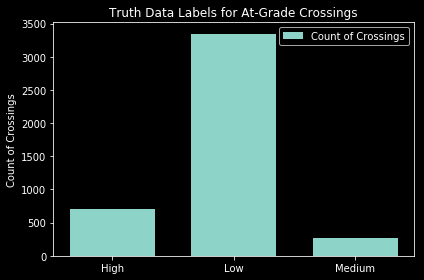

In [115]:
fig, ax = plt.subplots()
x = np.arange(len(stats_df['Risk_Level']))
width = 0.7

rects1 = ax.bar(x, stats_df['wcoordinateID'], width, label = 'Count of Crossings')
#rects2 = ax.bar(x + width/2, mode2_stats_df['Total Fatalities'], width, label = 'Incidents w Fatalities')

ax.set_title('Truth Data Labels for At-Grade Crossings')
ax.set_ylabel('Count of Crossings')
ax.set_xticks(x)
ax.set_xticklabels(stats_df['Risk_Level'])
ax.legend()

fig.tight_layout()

plt.show()

In [116]:
stats_df = test_set.groupby(['Risk_Level'])['wcoordinateID'].count().reset_index().sort_values('wcoordinateID')

stats_df

,Risk_Level,wcoordinateID
2,Medium,7
0,High,106
1,Low,423


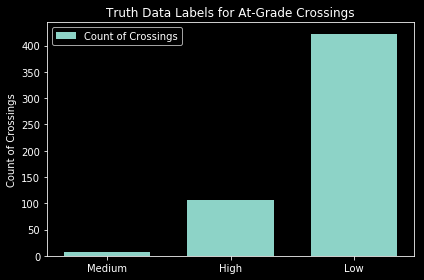

In [117]:
fig, ax = plt.subplots()
x = np.arange(len(stats_df['Risk_Level']))
width = 0.7

rects1 = ax.bar(x, stats_df['wcoordinateID'], width, label = 'Count of Crossings')
#rects2 = ax.bar(x + width/2, mode2_stats_df['Total Fatalities'], width, label = 'Incidents w Fatalities')

ax.set_title('Truth Data Labels for At-Grade Crossings')
ax.set_ylabel('Count of Crossings')
ax.set_xticks(x)
ax.set_xticklabels(stats_df['Risk_Level'])
ax.legend()

fig.tight_layout()

plt.show()

In [118]:
#test_set['Risk_Level'] = test_set['Incident Count'].apply(lambda x: risk_in_21(x))

In [119]:
stats_df = test_set.groupby(['Risk_Level'])['wcoordinateID'].count().reset_index().sort_values('wcoordinateID')

stats_df

,Risk_Level,wcoordinateID
2,Medium,7
0,High,106
1,Low,423


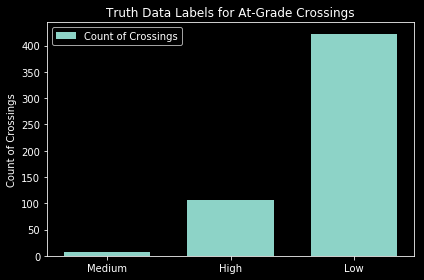

In [120]:
fig, ax = plt.subplots()
x = np.arange(len(stats_df['Risk_Level']))
width = 0.7

rects1 = ax.bar(x, stats_df['wcoordinateID'], width, label = 'Count of Crossings')
#rects2 = ax.bar(x + width/2, mode2_stats_df['Total Fatalities'], width, label = 'Incidents w Fatalities')

ax.set_title('Truth Data Labels for At-Grade Crossings')
ax.set_ylabel('Count of Crossings')
ax.set_xticks(x)
ax.set_xticklabels(stats_df['Risk_Level'])
ax.legend()

fig.tight_layout()

plt.show()

In [121]:
feature_set_df.shape

(4870, 26)

In [122]:
feature_set_df.columns

Index(['ID', 'wcoordinateID', 'incident_year_month', 'Max Daily Precipitation',
       'Max Daily Snow', 'Max Daily Snow Depth', 'Max Daily TempMax',
       'Max Daily TempMin', 'Min Daily Precipitation', 'Min Daily Snow',
       'Min Daily Snow Depth', 'Min Daily TempMax', 'Min Daily TempMin',
       'Mean Daily Precipitation', 'Mean Daily Snow', 'Mean Daily Snow Depth',
       'Mean Daily TempMax', 'Mean Daily TempMin', 'ELEV',
       'Maintenance Parent Railroad Code', 'Railroad Type', 'Track Type Code',
       'State', 'County', 'Incident Count', 'Risk_Level'],
      dtype='object')

In [123]:
#feature_set_df = feature_set_df.merge(noaa_station_aggs_df, how='inner', on=['ID'])

In [124]:
feature_set_df.shape

(4870, 26)

In [125]:
feature_set_df.head()

,ID,wcoordinateID,incident_year_month,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,...,Mean Daily TempMax,Mean Daily TempMin,ELEV,Maintenance Parent Railroad Code,Railroad Type,Track Type Code,State,County,Incident Count,Risk_Level
0,USC00182282,"(39.6, -78.8)",2016_1,373.0,442.0,533.0,128.0,17.0,0.0,0.0,...,35.903226,-75.677419,222.5,CSX,CL,2.0,MARYLAND,ALLEGANY,0.0,Low
1,USC00182282,"(39.6, -78.8)",2016_1,373.0,442.0,533.0,128.0,17.0,0.0,0.0,...,35.903226,-75.677419,222.5,CSX,CL,1.0,MARYLAND,ALLEGANY,0.0,Low
2,USC00182282,"(39.6, -78.8)",2016_1,373.0,442.0,533.0,128.0,17.0,0.0,0.0,...,35.903226,-75.677419,222.5,CSX,CL,1.0,MARYLAND,ALLEGANY,0.0,Low
3,USC00182282,"(39.6, -78.8)",2016_10,203.0,0.0,0.0,300.0,156.0,0.0,0.0,...,208.967742,77.064516,222.5,CSX,CL,2.0,MARYLAND,ALLEGANY,0.0,Low
4,USC00182282,"(39.6, -78.8)",2016_10,203.0,0.0,0.0,300.0,156.0,0.0,0.0,...,208.967742,77.064516,222.5,CSX,CL,1.0,MARYLAND,ALLEGANY,0.0,Low


In [126]:
feature_set_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 26 columns):
ID                                  4870 non-null object
wcoordinateID                       4870 non-null object
incident_year_month                 4870 non-null object
Max Daily Precipitation             4870 non-null float64
Max Daily Snow                      3958 non-null float64
Max Daily Snow Depth                3955 non-null float64
Max Daily TempMax                   4828 non-null float64
Max Daily TempMin                   4828 non-null float64
Min Daily Precipitation             4870 non-null float64
Min Daily Snow                      3958 non-null float64
Min Daily Snow Depth                3955 non-null float64
Min Daily TempMax                   4828 non-null float64
Min Daily TempMin                   4828 non-null float64
Mean Daily Precipitation            4870 non-null float64
Mean Daily Snow                     3958 non-null float64
Mean Daily Snow Depth     

In [136]:
feature_set_df.describe()

,Max Daily Precipitation,Max Daily Snow,Max Daily Snow Depth,Max Daily TempMax,Max Daily TempMin,Min Daily Precipitation,Min Daily Snow,Min Daily Snow Depth,Min Daily TempMax,Min Daily TempMin,Mean Daily Precipitation,Mean Daily Snow,Mean Daily Snow Depth,Mean Daily TempMax,Mean Daily TempMin,ELEV,Track Type Code,Incident Count
count,4870.000000,3958.000000,3955.000000,4828.000000,4828.000000,4870.0,3958.0,3955.000000,4828.000000,4828.000000,4870.000000,3958.000000,3955.000000,4828.000000,4828.000000,4870.000000,4870.000000,4870.000000
mean,341.570637,38.264275,44.916056,274.721210,156.206089,0.0,0.0,0.886220,85.964374,-5.375932,34.412470,2.502245,10.224373,181.541804,74.792352,90.477269,1.469405,3.638398
std,224.563660,80.505171,97.252036,71.544474,71.271325,0.0,0.0,9.056737,105.254668,101.642048,17.973429,6.134548,33.974791,91.754191,86.331254,110.936625,1.045184,9.808751
min,0.000000,0.000000,0.000000,44.000000,-28.000000,0.0,0.0,0.000000,-217.000000,-283.000000,0.000000,0.000000,0.000000,-20.142857,-121.838710,6.100000,1.000000,0.000000
25%,206.000000,0.000000,0.000000,217.000000,94.000000,0.0,0.0,0.000000,-5.000000,-88.250000,21.142857,0.000000,0.000000,93.414516,-4.857143,33.800000,1.000000,0.000000
50%,290.000000,0.000000,0.000000,289.000000,167.000000,0.0,0.0,0.000000,78.000000,-11.000000,31.740476,0.000000,0.000000,185.295699,75.935484,33.800000,1.000000,0.000000
75%,424.000000,46.000000,51.000000,333.000000,217.000000,0.0,0.0,0.000000,189.000000,78.000000,44.533333,2.033333,1.805236,269.600000,152.066667,99.400000,1.000000,0.000000
max,1783.000000,813.000000,813.000000,383.000000,283.000000,0.0,0.0,203.000000,294.000000,200.000000,126.300000,96.333333,338.666667,336.806452,239.322581,413.900000,4.000000,55.000000


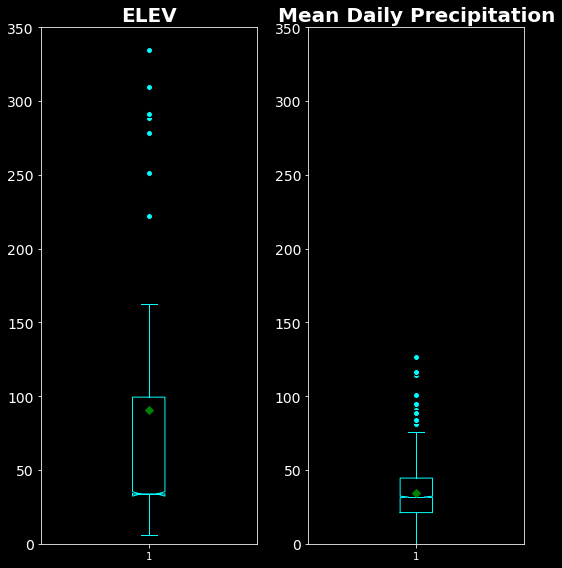

In [144]:
blue_circle = dict(markerfacecolor='cyan', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

df = feature_set_df[['ELEV',
                    'Mean Daily Precipitation',
#                    'Mean Daily Snow',
#                    'Mean Daily Snow Depth',
#                    'Mean Daily TempMax',
#                    'Mean Daily TempMin',
                   ]]
c = 'cyan'

fig, axs = plt.subplots(1, len(df.columns), figsize=(8,8))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df.iloc[:,i], boxprops=dict(color=c), capprops=dict(color=c), whiskerprops=dict(color=c), medianprops=dict(color=c), flierprops=blue_circle, showmeans=True, meanprops=mean_shape, notch=True, vert=True)
    ax.set_title(df.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, 350)
    
plt.tight_layout()
plt.show()

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

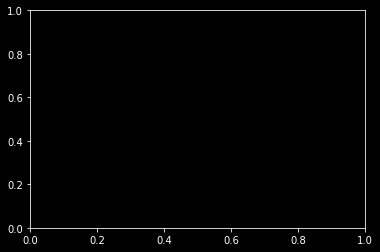

In [151]:
plt.hist(feature_set_df['Mean Daily TempMin'])

## 4. Prep for SciKitLearn:
____

In [127]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml, make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [128]:
COLOR = 'white'
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [129]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = ''
        else:
            title = ''

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

Define Key Information:

In [130]:
# classes to predict
classes = ['Low', 'Medium', 'High']

# set data_df = dataset
data_df = feature_set_df

# features definition
categorical_features = [
                        'State',
                        'County',
#                        'Maintenance Parent Railroad Code',
#                        'Railroad Type', 
#                        'Track Type Code',
                       ]

numeric_features = ['ELEV',
                    'Mean Daily Precipitation',
                    'Mean Daily Snow',
                    'Mean Daily Snow Depth',
                    'Mean Daily TempMax',
                    'Mean Daily TempMin',
                    'Max Daily Precipitation',
                    'Max Daily Snow',
                    'Max Daily Snow Depth',
                    'Max Daily TempMax',
                    'Max Daily TempMin',
                    'Min Daily Precipitation',
                    'Min Daily Snow',
                    'Min Daily Snow Depth',
                    'Min Daily TempMax',
                    'Min Daily TempMin',
                   ]

# X represents all feature columns
X = data_df.loc[:,(categorical_features + numeric_features)]
# note y should be a "Risk class" derived from # of incidents/injuries/fatalities somehow that matches 'classes' above
y = data_df['Risk_Level']

# classifiers to try
names = ["Decision Tree", "AdaBoost", "GradientBoost"]
classifiers = [DecisionTreeClassifier(max_depth=5),
               AdaBoostClassifier(),
               GradientBoostingClassifier(),
              ]

# training set ratios
# tsizes = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
tsizes = [0.7,0.8,0.9]

Transformation of Features:

In [131]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## 5. Model Building and Evaluation:
___

### Multi Class Test:

classifier: Decision Tree
test size: 0.7
f1_score:  0.6803931046669267
precision:  0.9304670002754091
recall:  0.6731855804231163
Normalized confusion matrix


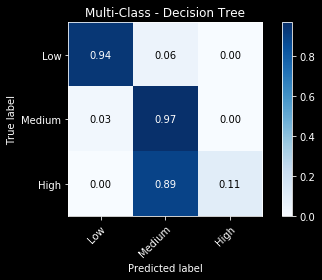

test size: 0.8
f1_score:  0.6810453765004297
precision:  0.7946526427811681
recall:  0.6656085825968892
Normalized confusion matrix


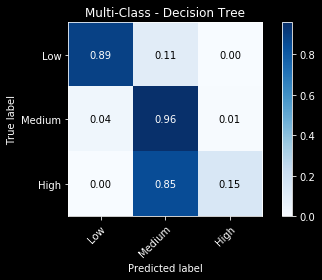

test size: 0.9
f1_score:  0.691422293340077
precision:  0.7591267719965155
recall:  0.6484550470167738
Normalized confusion matrix


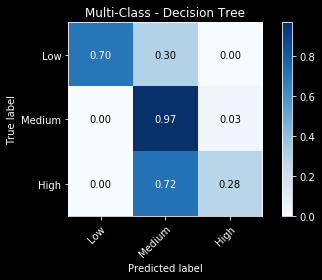

classifier: AdaBoost
test size: 0.7
f1_score:  0.4233682437035533
precision:  0.4181447013160568
recall:  0.43096732722745396
Normalized confusion matrix


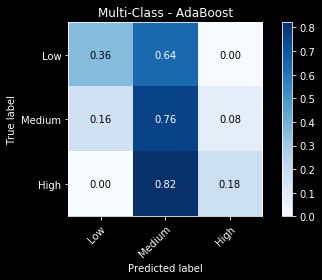

test size: 0.8
f1_score:  0.36081504702194356
precision:  0.5247877218128935
recall:  0.36094897283874583
Normalized confusion matrix


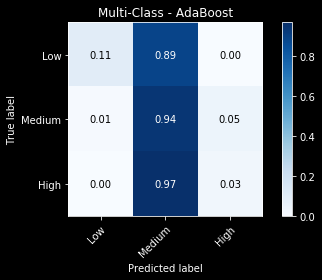

test size: 0.9
f1_score:  0.32398356617420454
precision:  0.4764399722414989
recall:  0.34900377082100875
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


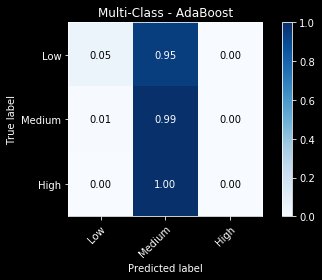

classifier: GradientBoost
test size: 0.7
f1_score:  0.9746492770053884
precision:  0.9965174129353235
recall:  0.9557004620029831
Normalized confusion matrix


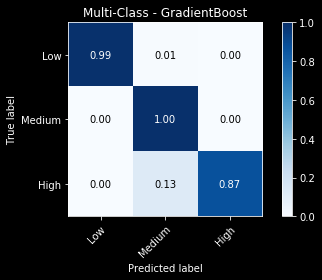

test size: 0.8
f1_score:  0.9307021670780689
precision:  0.9751648179666256
recall:  0.8960591051435361
Normalized confusion matrix


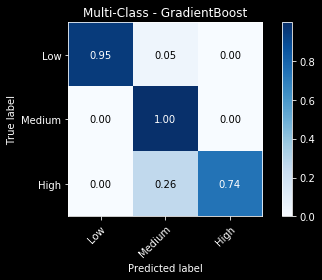

test size: 0.9
f1_score:  0.883046841964998
precision:  0.9688071812818335
recall:  0.8271209876616666
Normalized confusion matrix


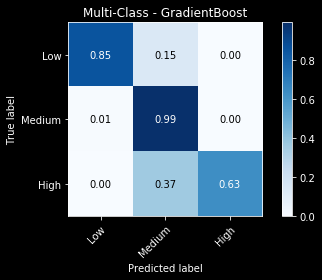

In [132]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )
    
    # establish empty tsize lists
    tsize_precision = []
    tsize_recall = []
    
    for tsize in tsizes:
        # print tsize being tested
        print(f'test size: {tsize}')
        # train, test, split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
        # fit model
        clf.fit(X_train, y_train)
        # get confusion matrix stats
        y_pred = clf.predict(X_test)
        N = confusion_matrix(y_test, y_pred, labels=classes)
        # note that in the above N, rows are true label, column predicted label, values indicate # of samples
        # utilize plot confusion matrix function from earlier
        print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
        print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
        print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
        plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                          normalize=True,
                          title="Multi-Class - {}".format(names[i]),
                          cmap=plt.cm.Blues)
        plt.show()


classifier: Decision Tree
test size: 0.7
f1_score:  0.26106696935300794
precision:  0.2510917030567686
recall:  0.2718676122931442
Normalized confusion matrix


c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


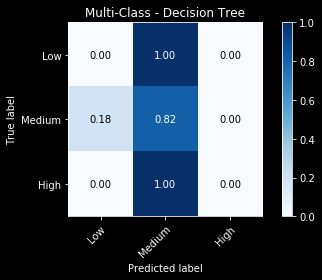

test size: 0.8

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



f1_score:  0.26106696935300794
precision:  0.2510917030567686
recall:  0.2718676122931442
Normalized confusion matrix


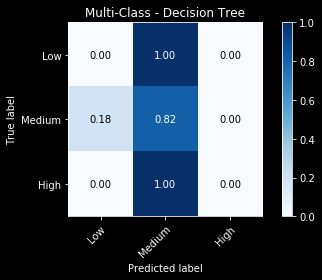

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


test size: 0.9
f1_score:  0.26106696935300794
precision:  0.2510917030567686
recall:  0.2718676122931442
Normalized confusion matrix


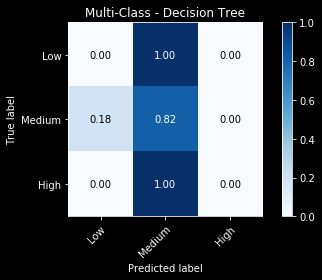

classifier: AdaBoost
test size: 0.7
f1_score:  0.39657573426435494
precision:  0.44060959914618447
recall:  0.4948927249208261
Normalized confusion matrix


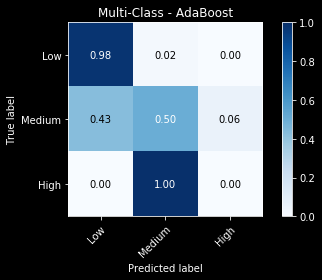

test size: 0.8
f1_score:  0.39657573426435494
precision:  0.44060959914618447
recall:  0.4948927249208261
Normalized confusion matrix


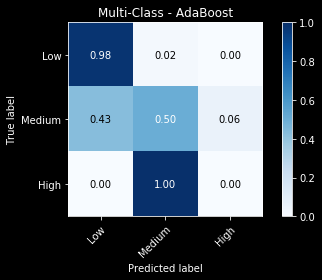

test size: 0.9
f1_score:  0.39657573426435494
precision:  0.44060959914618447
recall:  0.4948927249208261
Normalized confusion matrix


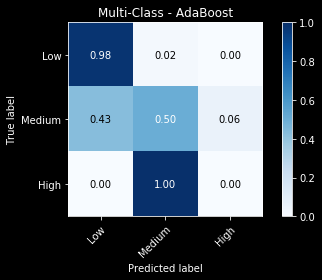

classifier: GradientBoost
test size: 0.7
f1_score:  0.2803603603603604
precision:  0.2583001328021248
recall:  0.3065405831363278
Normalized confusion matrix


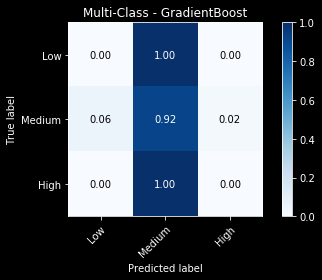

test size: 0.8
f1_score:  0.2803603603603604
precision:  0.2583001328021248
recall:  0.3065405831363278
Normalized confusion matrix


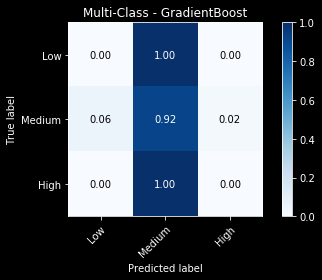

test size: 0.9
f1_score:  0.2803603603603604
precision:  0.2583001328021248
recall:  0.3065405831363278
Normalized confusion matrix


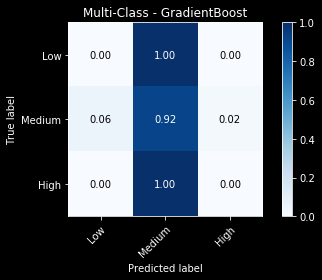

In [133]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )
    
    # establish empty tsize lists
    tsize_precision = []
    tsize_recall = []
    
    for tsize in tsizes:
        # print tsize being tested
        print(f'test size: {tsize}')
        # train, test, split
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
        X_train = train_set.drop('Risk_Level', 1)
        X_test = test_set.drop('Risk_Level', 1)
        y_train = train_set['Risk_Level']
        y_test = test_set['Risk_Level']
        
        # fit model
        clf.fit(X_train, y_train)
        # get confusion matrix stats
        y_pred = clf.predict(X_test)
        N = confusion_matrix(y_test, y_pred, labels=classes)
        # note that in the above N, rows are true label, column predicted label, values indicate # of samples
        # utilize plot confusion matrix function from earlier
        print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
        print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
        print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
        plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                          normalize=True,
                          title="Multi-Class - {}".format(names[i]),
                          cmap=plt.cm.Blues)
        plt.show()


### Binary Class Test:

In [134]:
# classes to predict
classes = ['Not-High', 'High']
feature_set_df['Risk_Level'] = ['Not-High' if x in ["Low"] else 'High' for x in feature_set_df['Risk_Level']]
train_set['Risk_Level'] = ['Not-High' if x in ["Low"] else 'High' for x in train_set['Risk_Level']]
test_set['Risk_Level'] = ['Not-High' if x in ["Low"] else 'High' for x in test_set['Risk_Level']]

c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\thoma\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


classifier: Decision Tree
test size: 0.7
f1_score:  0.6652725048865221
precision:  0.8802224517315185
recall:  0.6359079167450192
Normalized confusion matrix


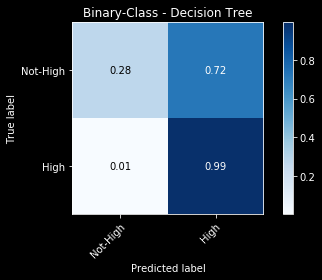

test size: 0.8
f1_score:  0.6946899880885211
precision:  0.8365080441862986
recall:  0.661954002930873
Normalized confusion matrix


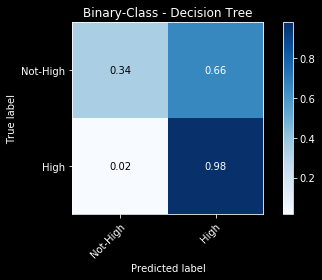

test size: 0.9
f1_score:  0.7505568427327236
precision:  0.7345152547337296
recall:  0.7811162277179303
Normalized confusion matrix


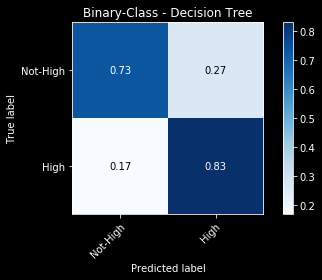

classifier: AdaBoost
test size: 0.7
f1_score:  0.940622116736807
precision:  0.956231180741709
recall:  0.9270513161524214
Normalized confusion matrix


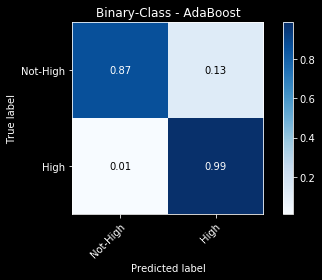

test size: 0.8
f1_score:  0.9206673031209376
precision:  0.9439513908699488
recall:  0.901799803732829
Normalized confusion matrix


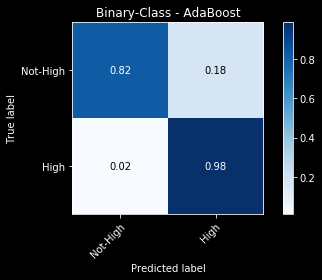

test size: 0.9
f1_score:  0.9213866308337233
precision:  0.9354006466103829
recall:  0.9091215196756528
Normalized confusion matrix


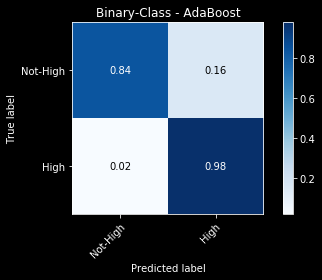

classifier: GradientBoost
test size: 0.7
f1_score:  0.9708460098552978
precision:  0.9876429361859093
recall:  0.9562091503267973
Normalized confusion matrix


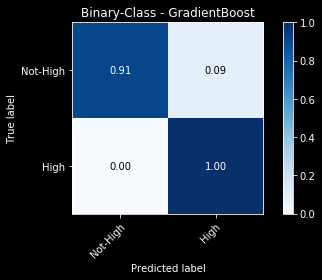

test size: 0.8
f1_score:  0.955000919563423
precision:  0.9764092651334919
recall:  0.9370630814765303
Normalized confusion matrix


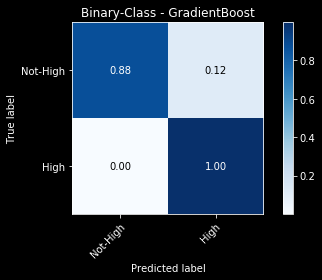

test size: 0.9
f1_score:  0.9339108484479868
precision:  0.9564594207875834
recall:  0.9153678036946189
Normalized confusion matrix


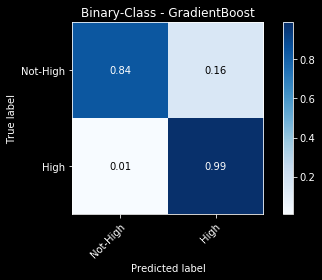

In [137]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )
    
    # establish empty tsize lists
    tsize_precision = []
    tsize_recall = []
    
    for tsize in tsizes:
        # print tsize being tested
        print(f'test size: {tsize}')
        # train, test, split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
        # fit model
        clf.fit(X_train, y_train)
        # get confusion matrix stats
        y_pred = clf.predict(X_test)
        N = confusion_matrix(y_test, y_pred, labels=classes)
        # note that in the above N, rows are true label, column predicted label, values indicate # of samples
        # utilize plot confusion matrix function from earlier
        print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
        print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
        print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
        plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                          normalize=True,
                          title="Binary-Class - {}".format(names[i]),
                          cmap=plt.cm.Blues)
        plt.show()

classifier: Decision Tree
test size: 0.7
f1_score:  0.3716295427901524
precision:  0.3686046511627907
recall:  0.3747044917257683
Normalized confusion matrix


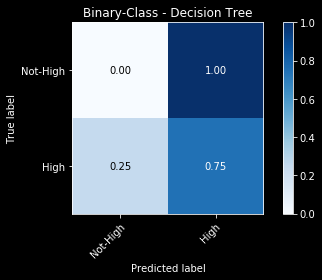

test size: 0.8
f1_score:  0.36568047337278103
precision:  0.36611374407582936
recall:  0.36524822695035464
Normalized confusion matrix


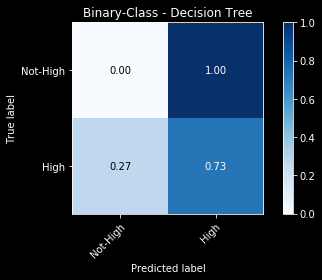

test size: 0.9
f1_score:  0.3716295427901524
precision:  0.3686046511627907
recall:  0.3747044917257683
Normalized confusion matrix


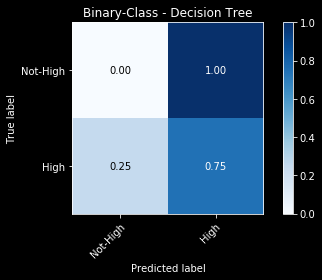

classifier: AdaBoost
test size: 0.7
f1_score:  0.4381551362683438
precision:  0.3935969868173258
recall:  0.4940898345153664
Normalized confusion matrix


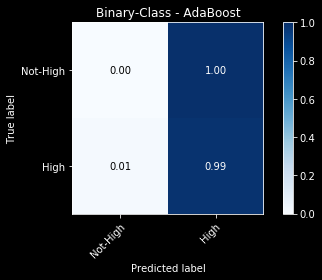

test size: 0.8
f1_score:  0.4381551362683438
precision:  0.3935969868173258
recall:  0.4940898345153664
Normalized confusion matrix


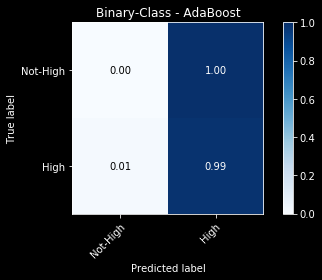

test size: 0.9
f1_score:  0.4381551362683438
precision:  0.3935969868173258
recall:  0.4940898345153664
Normalized confusion matrix


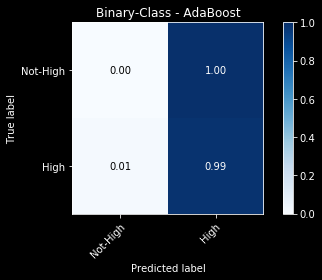

classifier: GradientBoost
test size: 0.7
f1_score:  0.42550911039657024
precision:  0.3892156862745098
recall:  0.46926713947990545
Normalized confusion matrix


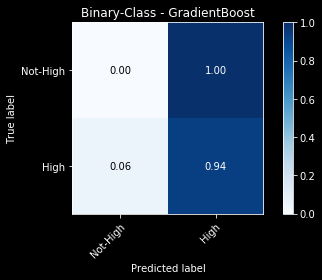

test size: 0.8
f1_score:  0.42550911039657024
precision:  0.3892156862745098
recall:  0.46926713947990545
Normalized confusion matrix


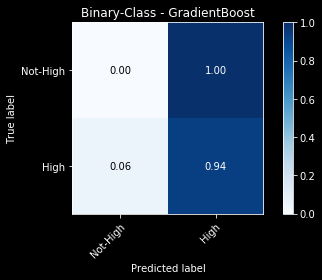

test size: 0.9
f1_score:  0.42550911039657024
precision:  0.3892156862745098
recall:  0.46926713947990545
Normalized confusion matrix


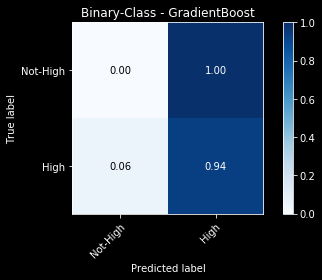

In [135]:
i = -1

for classifier in classifiers:
    # print name of classifier
    i += 1
    print('classifier: {}'.format(names[i]))
    # establish pipe
    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )
    
    # establish empty tsize lists
    tsize_precision = []
    tsize_recall = []
    
    for tsize in tsizes:
        # print tsize being tested
        print(f'test size: {tsize}')
        # train, test, split
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize)
        X_train = train_set.drop('Risk_Level', 1)
        X_test = test_set.drop('Risk_Level', 1)
        y_train = train_set['Risk_Level']
        y_test = test_set['Risk_Level']
        # fit model
        clf.fit(X_train, y_train)
        # get confusion matrix stats
        y_pred = clf.predict(X_test)
        N = confusion_matrix(y_test, y_pred, labels=classes)
        # note that in the above N, rows are true label, column predicted label, values indicate # of samples
        # utilize plot confusion matrix function from earlier
        print('f1_score:  {}'.format(f1_score(y_test, y_pred, average="macro")))
        print('precision:  {}'.format(precision_score(y_test, y_pred, average="macro")))
        print('recall:  {}'.format(recall_score(y_test, y_pred, average="macro")))
        plot_confusion_matrix(y_test, clf.predict(X_test), classes,
                          normalize=True,
                          title="Binary-Class - {}".format(names[i]),
                          cmap=plt.cm.Blues)
        plt.show()